In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [74]:
def get_unique_values_with_counts(dataframe, column_name):
    """
    This function returns a dictionary with unique values in a specified column of a dataframe
    and their corresponding counts.
    
    Parameters:
    dataframe (pd.DataFrame): The dataframe containing the data.
    column_name (str): The name of the column to extract unique values and counts from.
    
    Returns:
    dict: A dictionary where keys are unique values and values are their counts.
    """
    value_counts = dataframe[column_name].value_counts()
    return value_counts.to_dict()

# Function to find keywords in specified columns
def find_keywords(row, columns, keywords):
    found_keywords = []
    for column in columns:
        for keyword in keywords:
            if pd.notna(row[column]) and keyword in row[column]:
                found_keywords.append(keyword)
    return found_keywords

def plot_failure_rate_by_column(df, column, status_filter, threshold=None):
    """
    Plots the failure rate by a given column in the DataFrame.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    column (str): The column to group by and plot the failure rate.
    status_filter (str): The project status to filter on. Used for the chart title.
    threshold (float): An optional threshold to filter the failure rate. Defaults to None.
    
    Returns:
    None
    """
    # Calculate the failure rate and the ratio of num_failed/total
    grouped = df.groupby(column).agg(
        num_failed=('failure', 'sum'),
        total=('failure', 'size')
    )
    grouped['failure_rate'] = grouped['num_failed'] / grouped['total']
    
    # If a threshold is provided, filter the failure rate
    if threshold is not None:
        grouped = grouped[grouped['failure_rate'] >= threshold]
    
    # Sort the failure rate
    grouped = grouped.sort_values(by='failure_rate', ascending=False)
    
    # Plot the failure rate
    plt.figure(figsize=(12, 8))
    bars = plt.bar(grouped.index, grouped['failure_rate'], color='skyblue')
    plt.title(f'Failure Rate by {column.replace("_", " ").title()} (where project status == "{status_filter}")')
    plt.xlabel(column.replace('_', ' ').title())
    plt.ylabel('Failure Rate')
    plt.xticks(rotation=45, ha='right')
    
    # Add text annotations on top of the bars
    for bar, num_failed, total in zip(bars, grouped['num_failed'], grouped['total']):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{num_failed}/{total}', 
                 ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

In [75]:
df = pd.read_csv("https://datasocibmproject.s3.ap-southeast-2.amazonaws.com/structured_data/capital_project_schedules_and_budgets_1.csv")
df = df.drop(df.columns[0], axis=1)

df = df[df['project_status_name'] == 'Complete']
df.to_csv('ibm_complete.csv', index=False)
df = df.drop(columns=['project_status_name'])

df.shape

(2981, 14)

In [76]:
get_unique_values_with_counts(df, 'failure')

{False: 2773, True: 208}

In [77]:
# Checking for missing values in the dataset
missing_values = df.isnull().sum()
missing_values

df['project_phase_name'] = df['project_phase_name'].fillna('Unknown')

# Verify if the missing values have been handled
missing_values_after = df.isnull().sum()
missing_values_after

project_geographic_district                                   0
project_building_identifier                                   0
project_school_name                                           0
project_type                                                  0
project_description                                           0
project_phase_name                                            0
project_phase_actual_start_date                               0
project_phase_planned_end_date                                0
project_phase_actual_end_date                                 0
project_budget_amount                                         0
final_estimate_of_actual_costs_through_end_of_phase_amount    0
total_phase_actual_spending_amount                            0
dsf_number_s                                                  0
failure                                                       0
dtype: int64

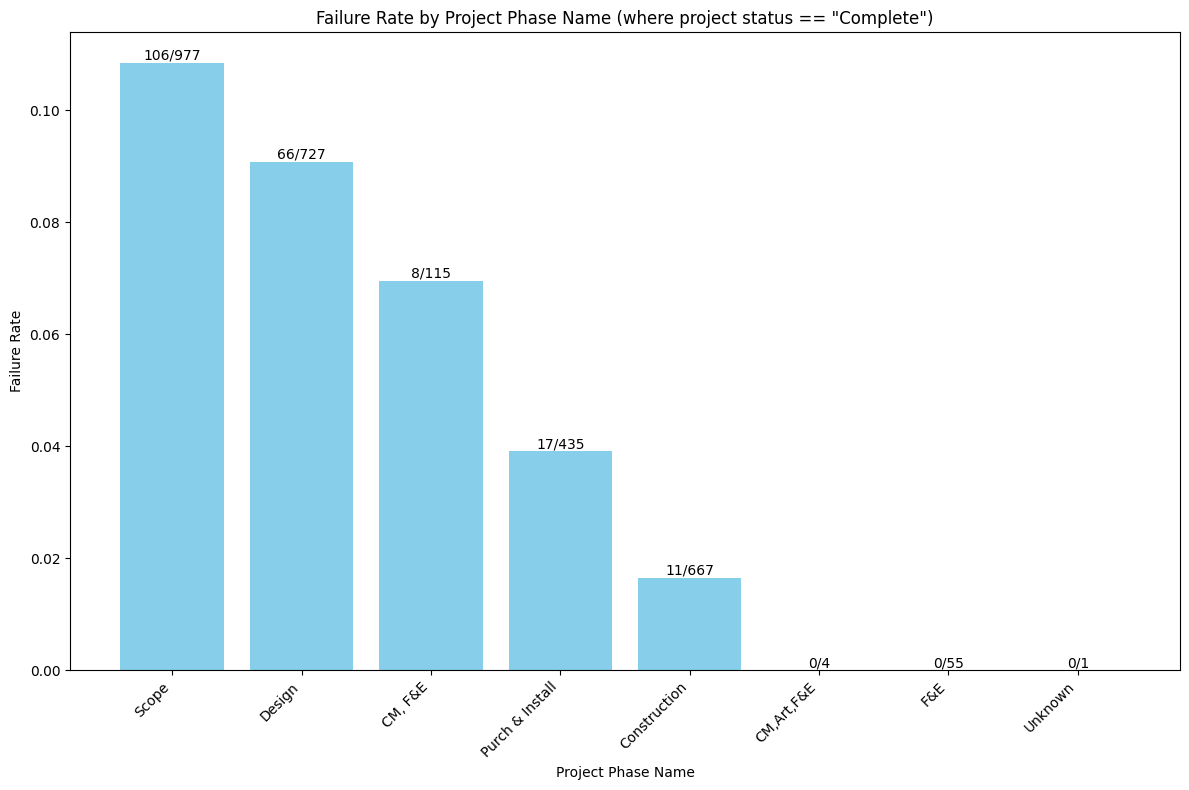

In [78]:
plot_failure_rate_by_column(df, 'project_phase_name', 'Complete')

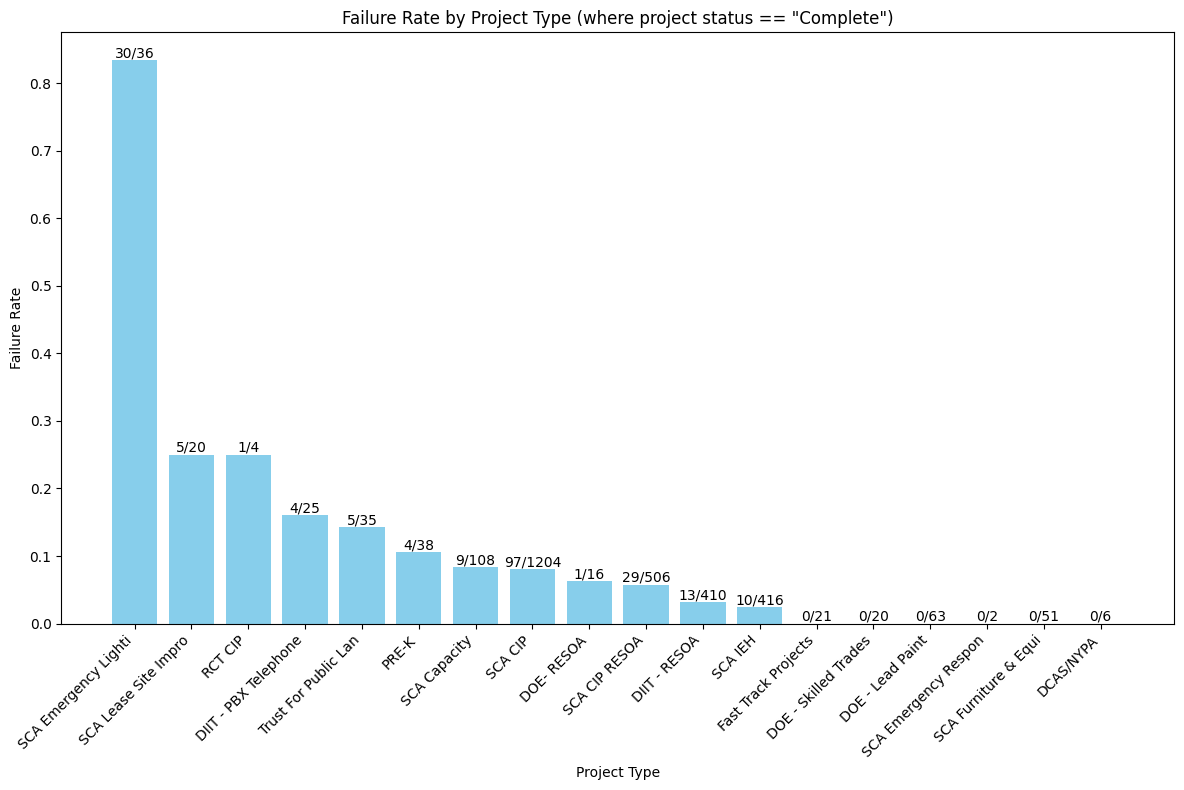

In [79]:
plot_failure_rate_by_column(df, 'project_type', 'Complete')

### Splitting by project type

In [81]:
project_types = [
    "SCA", "CIP", "DIIT", "DOE", "DOES", "DOER",
    "RESOA", "IEH", "PRE-K", "DCAS", "FY", "FAST TRACK PROJECTS"
]

df = df.map(lambda x: x.replace('PREK', 'PRE-K') if isinstance(x, str) else x)

# Columns to check for project types
columns_to_check = ['project_type', 'project_phase_planned_end_date']

# Apply the function to each row
df['project_type_split'] = df.apply(lambda row: find_keywords(row, columns_to_check, project_types), axis=1)

# Explode the list into separate rows
df_exploded = df.explode('project_type_split')

# Filter out rows where 'project_type_split' is NaN
df_exploded = df_exploded[df_exploded['project_type_split'].notna()]

In [82]:
# Checking for duplicate rows
duplicate_rows = df_exploded.duplicated().sum()

# Removing duplicate rows if any
df_cleaned = df_exploded.drop_duplicates()

duplicate_rows, df_cleaned.shape

(479, (5983, 15))

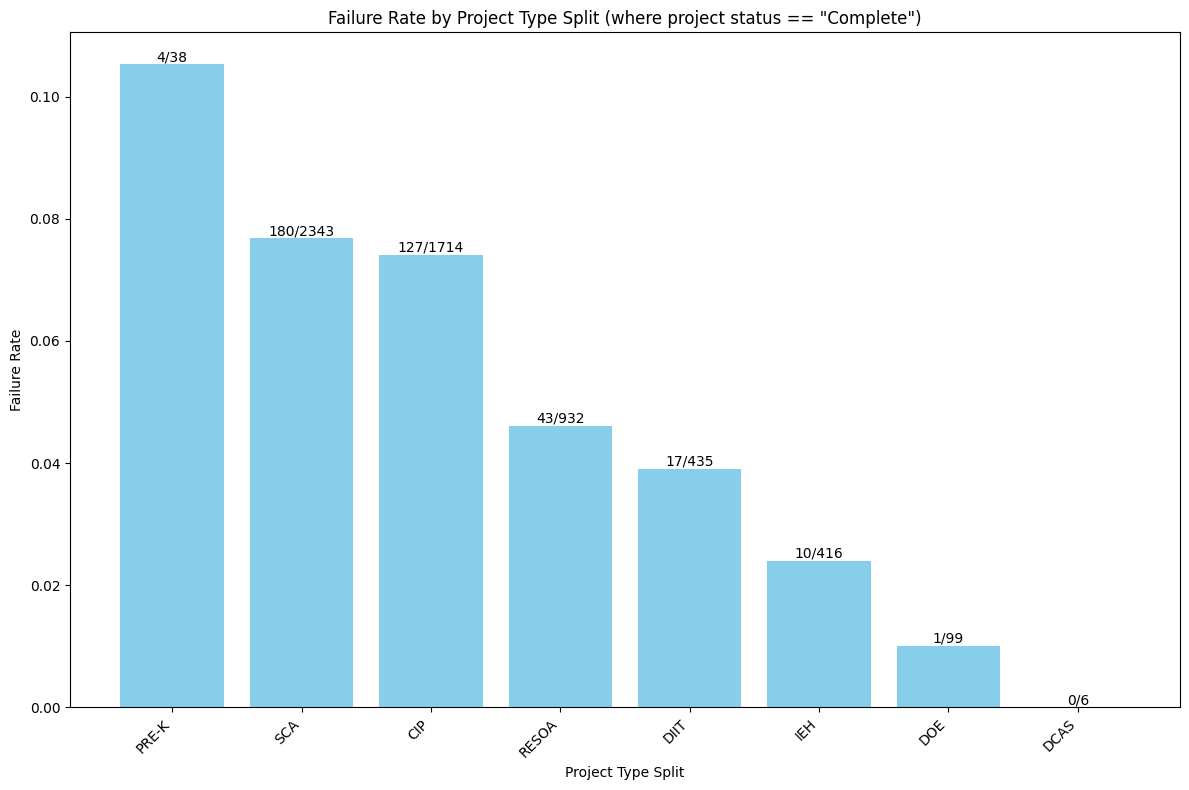

In [83]:
plot_failure_rate_by_column(df_cleaned, 'project_type_split', 'Complete')

### The code below are just some testing/exploring (useless)

In [84]:
df_cleaned['dsf_number_s'] = df_cleaned['dsf_number_s'].str.replace('DSF: ', '')
df_cleaned['dsf_number_s'] = df_cleaned['dsf_number_s'].str.replace('DSF:', '')

df_cleaned

/var/folders/l7/rfx8sr1s2h32jhyxdrb33h_40000gn/T/ipykernel_15693/3745202402.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['dsf_number_s'] = df_cleaned['dsf_number_s'].str.replace('DSF: ', '')
/var/folders/l7/rfx8sr1s2h32jhyxdrb33h_40000gn/T/ipykernel_15693/3745202402.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['dsf_number_s'] = df_cleaned['dsf_number_s'].str.replace('DSF:', '')


,project_geographic_district,project_building_identifier,project_school_name,project_type,project_description,project_phase_name,project_phase_actual_start_date,project_phase_planned_end_date,project_phase_actual_end_date,project_budget_amount,final_estimate_of_actual_costs_through_end_of_phase_amount,total_phase_actual_spending_amount,dsf_number_s,failure,project_type_split
2,10,X254,I.S. 254 - BRONX,SCA CIP RESOA,FY16 RESO A IP SURVEILLANCE CAMERA INSTALLATION,Scope,07/27/2017,11/27/2017,08/03/2017,0,1792.0,1792.0,0000823560,False,SCA
2,10,X254,I.S. 254 - BRONX,SCA CIP RESOA,FY16 RESO A IP SURVEILLANCE CAMERA INSTALLATION,Scope,07/27/2017,11/27/2017,08/03/2017,0,1792.0,1792.0,0000823560,False,CIP
2,10,X254,I.S. 254 - BRONX,SCA CIP RESOA,FY16 RESO A IP SURVEILLANCE CAMERA INSTALLATION,Scope,07/27/2017,11/27/2017,08/03/2017,0,1792.0,1792.0,0000823560,False,RESOA
6,10,X254,I.S. 254 - BRONX,DIIT - RESOA,FY17 RESO A TECHNOLOGY,Purch & Install,05/15/2017,01/15/2018,09/14/2017,50000,49625.0,49625.0,0000844624,False,DIIT
6,10,X254,I.S. 254 - BRONX,DIIT - RESOA,FY17 RESO A TECHNOLOGY,Purch & Install,05/15/2017,01/15/2018,09/14/2017,50000,49625.0,49625.0,0000844624,False,RESOA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8176,32,K799,ALC - BROOKLYN CHOICES,SCA CIP,EXT MASONRY/WINDOWS/PARAPETS/ROOFS,Scope,08/10/2015,12/28/2015,03/28/2016,97918,90549.0,90549.0,"0000822169, 0000843221, 0000843222, 0000843223",False,CIP
8177,32,K799,ALC - BROOKLYN CHOICES,SCA CIP,EXT MASONRY/WINDOWS/PARAPETS/ROOFS,Design,06/24/2016,11/28/2016,02/07/2017,382688,366145.0,312034.0,"0000822169, 0000843221, 0000843222, 0000843223",False,SCA
8177,32,K799,ALC - BROOKLYN CHOICES,SCA CIP,EXT MASONRY/WINDOWS/PARAPETS/ROOFS,Design,06/24/2016,11/28/2016,02/07/2017,382688,366145.0,312034.0,"0000822169, 0000843221, 0000843222, 0000843223",False,CIP
8181,32,K865,BUSHWICK LEADERS - K,SCA CIP,CERTIFICATE OF OCCUPANCY,Scope,06/18/2013,12/02/2013,11/18/2013,93274,124725.0,118749.0,0000776207,False,SCA


In [85]:
# Split the 'numbers' column into a list of numbers
df_cleaned['dsf_number_s'] = df_cleaned['dsf_number_s'].str.split(', ')

# Explode the 'numbers' column so each row contains only one number
df_exploded = df_cleaned.explode('dsf_number_s').reset_index(drop=True)

df_exploded

/var/folders/l7/rfx8sr1s2h32jhyxdrb33h_40000gn/T/ipykernel_15693/1359706375.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['dsf_number_s'] = df_cleaned['dsf_number_s'].str.split(', ')


,project_geographic_district,project_building_identifier,project_school_name,project_type,project_description,project_phase_name,project_phase_actual_start_date,project_phase_planned_end_date,project_phase_actual_end_date,project_budget_amount,final_estimate_of_actual_costs_through_end_of_phase_amount,total_phase_actual_spending_amount,dsf_number_s,failure,project_type_split
0,10,X254,I.S. 254 - BRONX,SCA CIP RESOA,FY16 RESO A IP SURVEILLANCE CAMERA INSTALLATION,Scope,07/27/2017,11/27/2017,08/03/2017,0,1792.0,1792.0,0000823560,False,SCA
1,10,X254,I.S. 254 - BRONX,SCA CIP RESOA,FY16 RESO A IP SURVEILLANCE CAMERA INSTALLATION,Scope,07/27/2017,11/27/2017,08/03/2017,0,1792.0,1792.0,0000823560,False,CIP
2,10,X254,I.S. 254 - BRONX,SCA CIP RESOA,FY16 RESO A IP SURVEILLANCE CAMERA INSTALLATION,Scope,07/27/2017,11/27/2017,08/03/2017,0,1792.0,1792.0,0000823560,False,RESOA
3,10,X254,I.S. 254 - BRONX,DIIT - RESOA,FY17 RESO A TECHNOLOGY,Purch & Install,05/15/2017,01/15/2018,09/14/2017,50000,49625.0,49625.0,0000844624,False,DIIT
4,10,X254,I.S. 254 - BRONX,DIIT - RESOA,FY17 RESO A TECHNOLOGY,Purch & Install,05/15/2017,01/15/2018,09/14/2017,50000,49625.0,49625.0,0000844624,False,RESOA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9142,32,K799,ALC - BROOKLYN CHOICES,SCA CIP,EXT MASONRY/WINDOWS/PARAPETS/ROOFS,Design,06/24/2016,11/28/2016,02/07/2017,382688,366145.0,312034.0,0000843221,False,CIP
9143,32,K799,ALC - BROOKLYN CHOICES,SCA CIP,EXT MASONRY/WINDOWS/PARAPETS/ROOFS,Design,06/24/2016,11/28/2016,02/07/2017,382688,366145.0,312034.0,0000843222,False,CIP
9144,32,K799,ALC - BROOKLYN CHOICES,SCA CIP,EXT MASONRY/WINDOWS/PARAPETS/ROOFS,Design,06/24/2016,11/28/2016,02/07/2017,382688,366145.0,312034.0,0000843223,False,CIP
9145,32,K865,BUSHWICK LEADERS - K,SCA CIP,CERTIFICATE OF OCCUPANCY,Scope,06/18/2013,12/02/2013,11/18/2013,93274,124725.0,118749.0,0000776207,False,SCA


In [86]:
# df_exploded = df_exploded[['project_phase_name', 'dsf_number_s']]

In [87]:
# # Checking for duplicate rows
# duplicate_rows = df_exploded.duplicated().sum()

# # Removing duplicate rows if any
# df_cleaned = df_exploded.drop_duplicates()

# duplicate_rows, df_cleaned.shape

In [88]:
get_unique_values_with_counts(df_exploded, 'dsf_number_s')

{'': 69,
 '0000800354': 12,
 '0000822761': 12,
 '0000844816': 12,
 '0000800349': 12,
 '0000822618': 12,
 '0000844240': 12,
 '0000822337': 12,
 '0000822848': 12,
 '0000822329': 12,
 '0000822326': 12,
 '0000754751': 12,
 '0000800452': 12,
 '0000844204': 12,
 '0000822317': 12,
 '0000821686': 12,
 '0000822882': 12,
 '0000823595': 12,
 '0000844887': 12,
 '0000800028': 12,
 '0000844931': 12,
 '0000822782': 12,
 '0000844194': 12,
 '0000798846': 12,
 '0000798733': 12,
 '0000800389': 12,
 '0000798683': 12,
 '0000822322': 12,
 '0000754616': 12,
 '0000798833': 12,
 '0000822621': 12,
 '0000844220': 12,
 '0000844228': 12,
 '0000822872': 12,
 '0000801018': 12,
 '0000822890': 12,
 '0000843811': 12,
 '0000822735': 12,
 '0000822886': 12,
 '0000844969': 12,
 '0000822715': 12,
 '0000822812': 12,
 '0000822905': 12,
 '0000822825': 12,
 '0000822752': 12,
 '0000822316': 12,
 '0000798195': 10,
 '0000792877': 8,
 '0000788303': 8,
 '0000807157': 8,
 '0000865836': 8,
 '0000843890': 8,
 '0000791457': 8,
 '0000792

In [89]:
df_exploded[df_exploded['dsf_number_s'] == '0000822169']
df_exploded[df_exploded['dsf_number_s'] == '0000843221']
df_exploded[df_exploded['dsf_number_s'] == '0000843222']

# df_exploded[df_exploded['project_phase_name'] == 'Design']

,project_geographic_district,project_building_identifier,project_school_name,project_type,project_description,project_phase_name,project_phase_actual_start_date,project_phase_planned_end_date,project_phase_actual_end_date,project_budget_amount,final_estimate_of_actual_costs_through_end_of_phase_amount,total_phase_actual_spending_amount,dsf_number_s,failure,project_type_split
9131,32,K799,ALC - BROOKLYN CHOICES,SCA CIP,EXT MASONRY/WINDOWS/PARAPETS/ROOFS,Scope,08/10/2015,12/28/2015,03/28/2016,97918,90549.0,90549.0,0000843222,False,SCA
9135,32,K799,ALC - BROOKLYN CHOICES,SCA CIP,EXT MASONRY/WINDOWS/PARAPETS/ROOFS,Scope,08/10/2015,12/28/2015,03/28/2016,97918,90549.0,90549.0,0000843222,False,CIP
9139,32,K799,ALC - BROOKLYN CHOICES,SCA CIP,EXT MASONRY/WINDOWS/PARAPETS/ROOFS,Design,06/24/2016,11/28/2016,02/07/2017,382688,366145.0,312034.0,0000843222,False,SCA
9143,32,K799,ALC - BROOKLYN CHOICES,SCA CIP,EXT MASONRY/WINDOWS/PARAPETS/ROOFS,Design,06/24/2016,11/28/2016,02/07/2017,382688,366145.0,312034.0,0000843222,False,CIP


In [90]:
df[df['dsf_number_s'].str.contains('0000822169')]
# df[df['dsf_number_s'].str.contains('0000843221')]
# df[df['dsf_number_s'].str.contains('0000843222')]


,project_geographic_district,project_building_identifier,project_school_name,project_type,project_description,project_phase_name,project_phase_actual_start_date,project_phase_planned_end_date,project_phase_actual_end_date,project_budget_amount,final_estimate_of_actual_costs_through_end_of_phase_amount,total_phase_actual_spending_amount,dsf_number_s,failure,project_type_split
8176,32,K799,ALC - BROOKLYN CHOICES,SCA CIP,EXT MASONRY/WINDOWS/PARAPETS/ROOFS,Scope,08/10/2015,12/28/2015,03/28/2016,97918,90549.0,90549.0,"DSF: 0000822169, 0000843221, 0000843222, 00008...",False,"[SCA, CIP]"
8177,32,K799,ALC - BROOKLYN CHOICES,SCA CIP,EXT MASONRY/WINDOWS/PARAPETS/ROOFS,Design,06/24/2016,11/28/2016,02/07/2017,382688,366145.0,312034.0,"DSF: 0000822169, 0000843221, 0000843222, 00008...",False,"[SCA, CIP]"


In [91]:
df

,project_geographic_district,project_building_identifier,project_school_name,project_type,project_description,project_phase_name,project_phase_actual_start_date,project_phase_planned_end_date,project_phase_actual_end_date,project_budget_amount,final_estimate_of_actual_costs_through_end_of_phase_amount,total_phase_actual_spending_amount,dsf_number_s,failure,project_type_split
2,10,X254,I.S. 254 - BRONX,SCA CIP RESOA,FY16 RESO A IP SURVEILLANCE CAMERA INSTALLATION,Scope,07/27/2017,11/27/2017,08/03/2017,0,1792.0,1792.0,DSF: 0000823560,False,"[SCA, CIP, RESOA]"
6,10,X254,I.S. 254 - BRONX,DIIT - RESOA,FY17 RESO A TECHNOLOGY,Purch & Install,05/15/2017,01/15/2018,09/14/2017,50000,49625.0,49625.0,DSF: 0000844624,False,"[DIIT, RESOA]"
7,10,X254,I.S. 254 - BRONX,DIIT - RESOA,FY17 RESO A TECHNOLOGY,Purch & Install,05/15/2017,01/15/2018,09/14/2017,76250,75677.0,75677.0,DSF: 0000845571,False,"[DIIT, RESOA]"
8,10,X279,P.S. 279 - BRONX,SCA CIP,WATER PENETRATION/ROOFS,Scope,08/02/2016,12/19/2016,02/13/2017,36881,57074.0,56288.0,"DSF: 0000820035, 0000866151",False,"[SCA, CIP]"
9,10,X279,P.S. 279 - BRONX,SCA CIP,WATER PENETRATION/ROOFS,Design,05/15/2017,10/16/2017,12/18/2017,141246,183396.0,180358.0,"DSF: 0000820035, 0000866151",False,"[SCA, CIP]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8172,32,K677,P.S. 677 - BROOKLYN,SCA Lease Site Impro,LEASE,Construction,12/05/2016,12/04/2017,08/11/2017,3551130,3563765.0,3377235.0,DSF: 0000843676,False,[SCA]
8173,32,K677,P.S. 677 - BROOKLYN,SCA Lease Site Impro,LEASE,"CM, F&E",12/05/2016,12/04/2017,08/11/2017,500070,406735.0,374706.0,DSF: 0000843676,False,[SCA]
8176,32,K799,ALC - BROOKLYN CHOICES,SCA CIP,EXT MASONRY/WINDOWS/PARAPETS/ROOFS,Scope,08/10/2015,12/28/2015,03/28/2016,97918,90549.0,90549.0,"DSF: 0000822169, 0000843221, 0000843222, 00008...",False,"[SCA, CIP]"
8177,32,K799,ALC - BROOKLYN CHOICES,SCA CIP,EXT MASONRY/WINDOWS/PARAPETS/ROOFS,Design,06/24/2016,11/28/2016,02/07/2017,382688,366145.0,312034.0,"DSF: 0000822169, 0000843221, 0000843222, 00008...",False,"[SCA, CIP]"


In [92]:
df_exploded.to_csv('complete_exploded.csv', index=False)